Note to Self: Goal of this Notebook is to Generate Features for Val and Test Sets. Complete in Sections.

## Import Libraries and Set Dependencies

Terminology:
-Dataset Table = dataframe containing retina pieces identified by date and section of retina and which recordings from those pieces we care about along with other pertinent analysis information (i.e. animal age, retinal eccentricity, etc.)
-Cell Table = dataframe containing cells identified in retinal pieces
-Unit Table = dataframe containing identified neurons (i.e. unit) where two units may relate to a single cell. Contains most of the information we care about EI, spike waveform, interspike interval
-Electrical Image (EI) = when recording a single cell spike, what is the average signal we record across a large array over time. Many possible features can be calculated from the EI.
-Spike Waveform = when recording a single cell spike, the average spike that occurs at the electrode that records the highest amplitudes of the EI

In [1]:
import importlib, os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
from icecream import ic

# Paths for cell display library, visionloader, axon conduction velocity caluclations
sys.path.append('../')
sys.path.append('/Volumes/Lab/Users/scooler/classification/')
sys.path.append("/Volumes/Lab/Users/mads/artificial-retina-software-pipeline/artificial-retina-software-pipeline/utilities/")
sys.path.append("/Volumes/Lab/Users/mads/cell_class/moosa_share/")

# Standard cell display library 
import cell_display_lib as cdl
import features as feat
import features_visual as feat_v
import features_electrical as feat_e
import deduplication
import features_DLelec as feat_dl
import features

# Specific feature libraries
import file_handling
from scipy.signal import spectrogram 
import scipy.signal as signal
import plotly.express as px
from sklearn.decomposition import PCA
import visionloader as vl
from conduction_velocity_code import get_axonal_conduction_velocity, upsample_ei, filter_ei_for_electrode_types
from scipy import stats
import eilib as el
import math
from skimage import measure
from cell_display_lib import show
import cv2
import re
pd.set_option('display.max_rows', None)

print('modules loaded! GO TIME')

# Your custom parameters
load_file = False
save_file = True
save_name = 'featExtract_test'  # customize this!
scratch_file_root = '/Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL' # replace my name!

/tmp/ipykernel_18063/1875288024.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


modules loaded! GO TIME


In [ ]:
# Or you could skip down to here and just load
load_file = 1
if load_file:
    importlib.reload(cdl)
    ct = cdl.CellTable()
    pieces = piece_run.keys()
    ct.file_load_pieces(pieces=pieces, file_root=scratch_file_root, process_labels=True)

## LOAD in Dataset Lists

In [28]:
# Gorish + Publishable Level Test Sets (512-array, vision)
dtlist = pd.read_csv('testval_sets.csv')
dtlist.columns = ['piece','path']
dtlist['run'] = '000' # Recording of interest
dtlist['sorter'] = 'vision' # Spike sorter used
# Create dataframe of pieces with paths, runs, and sorter specified (necessary info for initializing cell table)
for ind in range(len(dtlist)):
    dtlist.run[ind] = re.search(r'\d+', dtlist.path[ind][::-1]).group()[::-1]
    if 'kilosort' in dtlist.path[ind]:
        dtlist.sorter[ind] = 'kilosort'
    elif 'yass' in dtlist.path[ind]:
        dtlist.sorter[ind] = 'yass'

print(dtlist)

           piece                                          path  run    sorter
0   2005-04-06-0                          2005-04-06-0/data001  001    vision
1   2005-04-06-4  2005-04-06-4/pipeline_classification/data000  000    vision
2   2005-04-26-0  2005-04-26-0/pipeline_classification/data002  002    vision
3   2005-07-26-4  2005-07-26-4/pipeline_classification/data001  001    vision
4   2006-05-04-0                          2006-05-04-0/data000  000    vision
5   2006-05-04-2    2006-05-04-2/CT_EI_Analysis_Gorish/data005  005    vision
6   2006-07-14-1  2006-07-14-1/pipeline_classification/data012  012    vision
7   2006-11-01-2                          2006-11-01-2/data000  000    vision
8   2006-11-01-4                          2006-11-01-4/data000  000    vision
9   2007-02-06-1         2007-02-06-1/kilosort_data015/data015  015  kilosort
10  2007-02-06-4         2007-02-06-4/kilosort_data015/data015  015  kilosort
11  2007-02-06-6  2007-02-06-6/pipeline_classification/data007  

## Set Up Dataset_Table

In [36]:
# The dataset_table holds information about the datasets we want to work with, both their input properties (path)
# and their analysis (retinal location, animal, temperature, etc). First we make it outside the CellTable, then we let the CellTable
# hold it and take over

# Set up standard information for creating dataset_table for input into cell_table
print(f'Setting up {len(dtlist)} pieces')
index = []
dataset_dict = cdl.new_dataset_dict()

# Run through our initial dataframe and fill in information for each piece
for ind, row in dtlist.iterrows():
    piece_id, run_id = dtlist.piece[ind], dtlist.run[ind]
    path = (f'/Volumes/Analysis/' + dtlist.path[ind])
    if not os.path.isdir(path):
        print(f'Missing main vision analysis data {path}')
        continue
    label_mode, label_data_path, sta_path, ei_path = cdl.make_paths(piece_id, run_id) #Paths for labels made
    ei_path = '' #Do not use supersampled EI's (standard is fine)
    dataset_dict['run_id'].append(run_id) #Recording of interest
    dataset_dict['piece_id'].append(piece_id) #Piece of retina
    dataset_dict['note'].append('novel') 
    dataset_dict['path'].append(path) #Where the analysis lives
    dataset_dict['labels'].append(label_mode) #Labels for cell types
    dataset_dict['sorter'].append(dtlist.sorter[ind]) #Spike sorter used
    dataset_dict['label_data_path'].append(label_data_path) #Where labels live
    dataset_dict['sta_path'].append(sta_path) #Where visual stim lives (we will not be using this)
    dataset_dict['ei_path'].append(ei_path) #Where EI lives
    dataset_dict['stimulus_type'].append('whitenoise') #The type of visual stim used
    dataset_dict['species'].append('macaque') #Animal used
    index.append((piece_id, run_id))


dataset_table = pd.DataFrame(dataset_dict, index=pd.MultiIndex.from_tuples(index, names=['piece_id','run_id']))

# display(dataset_table)

Setting up 58 pieces
Missing 50-frame STA /Volumes/Scratch/Users/alexth/supersample-stas/2012-09-24-3/kilosort_data000/data000/data000.wu_sta
Missing long EI /Volumes/Scratch/Users/alexth/supersample-stas/2012-09-24-3/kilosort_data000/data000/data000.ei
Missing 50-frame STA /Volumes/Scratch/Users/alexth/supersample-stas/2015-09-23-2/kilosort_data000/data000/data000.wu_sta
Missing long EI /Volumes/Scratch/Users/alexth/supersample-stas/2015-09-23-2/kilosort_data000/data000/data000.ei
Missing 50-frame STA /Volumes/Scratch/Users/alexth/supersample-stas/2015-10-06-3/kilosort_data000/data000/data000.wu_sta
Missing long EI /Volumes/Scratch/Users/alexth/supersample-stas/2015-10-06-3/kilosort_data000/data000/data000.ei
Missing 50-frame STA /Volumes/Scratch/Users/alexth/supersample-stas/2015-11-09-3/kilosort_data000/data000/data000.wu_sta
Missing long EI /Volumes/Scratch/Users/alexth/supersample-stas/2015-11-09-3/kilosort_data000/data000/data000.ei
Missing 50-frame STA /Volumes/Scratch/Users/ale

In [37]:
# Drop rows of the array which throw dependency errors (missing data)
pd.options.display.max_rows = 4000
dataset_table = dataset_table.drop(index=('2006-05-04-2')) #Array Error
dataset_table = dataset_table.drop(index=('2006-11-01-2')) #No EI
dataset_table = dataset_table.drop(index=('2017-10-30-6')) #Label Issue
dataset_table = dataset_table.drop(index=('2018-03-01-6')) #Label Issue
display(dataset_table)

,,run_id,sorter,labels,piece_id,path,note,label_data_path,sta_path,ei_path,stimulus_type,species
piece_id,run_id,,,,,,,,,,,
2005-04-06-0,001,001,vision,vision,2005-04-06-0,/Volumes/Analysis/2005-04-06-0/data001,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2005-04-06-0/kilosort_data001/data001/data001.wu_sta,,whitenoise,macaque
2005-04-06-4,000,000,vision,vision,2005-04-06-4,/Volumes/Analysis/2005-04-06-4/pipeline_classification/data000,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2005-04-06-4/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2005-04-26-0,002,002,vision,vision,2005-04-26-0,/Volumes/Analysis/2005-04-26-0/pipeline_classification/data002,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2005-04-26-0/kilosort_data002/data002/data002.wu_sta,,whitenoise,macaque
2005-07-26-4,001,001,vision,vision,2005-07-26-4,/Volumes/Analysis/2005-07-26-4/pipeline_classification/data001,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2005-07-26-4/kilosort_data001/data001/data001.wu_sta,,whitenoise,macaque
2006-05-04-0,000,000,vision,vision,2006-05-04-0,/Volumes/Analysis/2006-05-04-0/data000,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2006-05-04-0/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2006-07-14-1,012,012,vision,vision,2006-07-14-1,/Volumes/Analysis/2006-07-14-1/pipeline_classification/data012,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2006-07-14-1/kilosort_data012/data012/data012.wu_sta,,whitenoise,macaque
2006-11-01-4,000,000,vision,vision,2006-11-01-4,/Volumes/Analysis/2006-11-01-4/data000,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2006-11-01-4/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2007-02-06-1,015,015,kilosort,vision,2007-02-06-1,/Volumes/Analysis/2007-02-06-1/kilosort_data015/data015,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2007-02-06-1/kilosort_data015/data015/data015.wu_sta,,whitenoise,macaque
2007-02-06-4,015,015,kilosort,vision,2007-02-06-4,/Volumes/Analysis/2007-02-06-4/kilosort_data015/data015,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2007-02-06-4/kilosort_data015/data015/data015.wu_sta,,whitenoise,macaque


In [38]:
# The CellTable lives in Cell Display Lib, a module full of functions that are useful for cell data handling
importlib.reload(cdl)
ct = cdl.CellTable()  # Initialize the core object, called the CellTable spelled 'ct'

~ Welcome to the CellTable ~experience~
~ 
~ Starting a fresh new CellTable


In [39]:
# Load the dataset_table we created into the ct (I do this in sections to protect against data loss in feature generation)
dataset_ids = ct.add_datasets(dataset_table.iloc[45:, :])

# The ct internal tables have pandas MultiIndexes as their indexes, so you use tuples to access individual rows
# for the datasets, the tuples are ('piece_id','run_id')
display(ct.dataset_table)

~ Adding 9 datasets


,,run_id,sorter,labels,piece_id,path,note,label_data_path,sta_path,ei_path,stimulus_type,species
piece_id,run_id,,,,,,,,,,,
2017-08-14-1,000,000,vision,vision,2017-08-14-1,/Volumes/Analysis/2017-08-14-1/data000-data001/data000,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2017-08-14-1/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2017-10-30-7,000,000,vision,vision,2017-10-30-7,/Volumes/Analysis/2017-10-30-7/data000-agg,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2017-10-30-7/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2018-02-06-4,000,000,vision,vision,2018-02-06-4,/Volumes/Analysis/2018-02-06-4/data000-agg,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2018-02-06-4/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2018-03-01-0,000,000,kilosort,alexandra,2018-03-01-0,/Volumes/Analysis/2018-03-01-0/kilosort_data000/data000,novel,/Volumes/Scratch/Users/alexth/all_data/2018-03-01-0/all_ids_2018-03-01-0_grant.mat,/Volumes/Scratch/Users/alexth/supersample-stas/2018-03-01-0/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2018-11-12-0,000,000,vision,alexandra,2018-11-12-0,/Volumes/Analysis/2018-11-12-0/data000-agg,novel,/Volumes/Scratch/Users/alexth/all_data/2018-11-12-0/all_ids_2018-11-12-0_last.mat,/Volumes/Scratch/Users/alexth/supersample-stas/2018-11-12-0/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2018-11-12-5,003,003,vision,vision,2018-11-12-5,/Volumes/Analysis/2018-11-12-5/data003,novel,,/Volumes/Scratch/Users/alexth/supersample-stas/2018-11-12-5/kilosort_data003/data003/data003.wu_sta,,whitenoise,macaque
2019-02-27-1,000,000,vision,alexandra,2019-02-27-1,/Volumes/Analysis/2019-02-27-1/data000,novel,/Volumes/Scratch/Users/alexth/all_data/2019-02-27-1/all_ids_2019-02-27-1_last.mat,/Volumes/Scratch/Users/alexth/supersample-stas/2019-02-27-1/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2019-11-07-0,000,000,vision,vision,2019-11-07-0,/Volumes/Analysis/2019-11-07-0/data000,novel,/Volumes/Analysis/2019-11-07-0/data000/data000.classification_agogliet.txt,/Volumes/Scratch/Users/alexth/supersample-stas/2019-11-07-0/kilosort_data000/data000/data000.wu_sta,,whitenoise,macaque
2022-05-16-3,005,005,vision,vision,2022-05-16-3,/Volumes/Analysis/2022-05-16-3/streamed/data005,novel,,,,whitenoise,macaque


In [40]:
# Initialize units (neurons detected) for each dataset
ct.initialize_units_for_datasets(dataset_ids)

# let's look at the unit_table, where most of the analysis is stored, which we have just filled with one row for every unit.
# Each unit is also indexed by a tuple: ('piece_id','run_id','unit_id'), the last of which is the familiar Vision ID,
# the output from the spike sorter. Note that these are not consecutive, but might be arranged on the electrode array.
# the table also has columns 'unit_id' and 'dataset_id' for easy access later and to keep things organized
# the column 'valid' is for excluding cells with basic errors, like having no spikes

~ Loading new units from MultiIndex([('2017-08-14-1', '000'),
            ('2017-10-30-7', '000'),
            ('2018-02-06-4', '000'),
            ('2018-03-01-0', '000'),
            ('2018-11-12-0', '000'),
            ('2018-11-12-5', '003'),
            ('2019-02-27-1', '000'),
            ('2019-11-07-0', '000'),
            ('2022-05-16-3', '005')],
           names=['piece_id', 'run_id']), currently have 9 datasets
~ Starting with unit_table having 0 units
~ Dataset ('2017-08-14-1', '000'): Loaded 380 units, sorter/alex indices 18 through 7611
~ Dataset ('2017-10-30-7', '000'): Loaded 576 units, sorter/alex indices 16 through 7666
~ Dataset ('2018-02-06-4', '000'): Loaded 603 units, sorter/alex indices 1 through 7669
~ Dataset ('2018-03-01-0', '000'): Loaded 1160 units, sorter/alex indices 1 through 1669
~ Dataset ('2018-11-12-0', '000'): Loaded 870 units, sorter/alex indices 1 through 7672
~ Dataset ('2018-11-12-5', '003'): Loaded 576 units, sorter/alex indices 4 through 7672


MultiIndex([('2017-08-14-1', '000'),
            ('2017-10-30-7', '000'),
            ('2018-02-06-4', '000'),
            ('2018-03-01-0', '000'),
            ('2018-11-12-0', '000'),
            ('2018-11-12-5', '003'),
            ('2019-02-27-1', '000'),
            ('2019-11-07-0', '000'),
            ('2022-05-16-3', '005')],
           names=['piece_id', 'run_id'])

In [51]:
# Features are how we generate the parameters that each cell has, which we use for analysis.
# We'll make our own feature in a later section

# a list of all of the features we want to run per-dataset
# each of these are subclasses of Feature
features_to_generate_by_dataset = [
    # general information
    feat.Feature_load_manual_labels,
    feat.Feature_load_dataset_metadata,

    # electrical (features from EI & recording information alone)
    feat_e.Feature_load_spike_times, feat_e.Feature_spikes_basic,
    feat_e.Feature_load_ei,
    feat_e.Feature_generate_acf_from_spikes,
    feat_e.Feature_spike_waveform,
    feat_e.Feature_ei_correlation_data,
    feat_e.Feature_ei_select_electrodes,
    feat_e.Feature_ei_map,

    # new feature functions for deep learning
    feat_dl.Feature_int_piece_id,
    feat_dl.Feature_spec_spike_waveform,
    feat_dl.Feature_spec_acf,
    feat_dl.Feature_retinal_eccentricity,
    feat_dl.Feature_map_early_ei_char,
    feat_dl.Feature_spike_char,
    feat_dl.Feature_axon_vel
    
]

# and then one feature to run overall, which sorts out the manual labels from text into integers
features_to_generate_overall = [feat.Feature_process_manual_labels]

# if the ct is very large we'll drop the big columns like STA and EI to save disk space, as they can be
# easily reloaded later as needed (we will not drop the big columns yet)
drop_big_columns = ct.unit_table.shape[0] > 10000
# Eventually remove ei because size varies depending on array and bins in calculation
big_columns_per_dataset = ['ei']

# now generate the features we listed above, and display the resulting units_table
# check out all of those new columns, which you can use to make your analysis
ct.generate_features('all', features_to_generate_by_dataset, features_to_generate_overall,
                     force_features=False,
                     load_analysis_data=True, #I changed this line
                     ignore_errors=False,
                     drop_big_columns=False,
                     big_columns_per_dataset=big_columns_per_dataset)
display(ct.unit_table)

~ Activating per-dataset features ["<class 'features.Feature_load_manual_labels'>", "<class 'features.Feature_load_dataset_metadata'>", "<class 'features_electrical.Feature_load_spike_times'>", "<class 'features_electrical.Feature_spikes_basic'>", "<class 'features_electrical.Feature_load_ei'>", "<class 'features_electrical.Feature_generate_acf_from_spikes'>", "<class 'features_electrical.Feature_spike_waveform'>", "<class 'features_electrical.Feature_ei_correlation_data'>", "<class 'features_electrical.Feature_ei_select_electrodes'>", "<class 'features_electrical.Feature_ei_map'>", "<class 'features_DLelec.Feature_int_piece_id'>", "<class 'features_DLelec.Feature_spec_spike_waveform'>", "<class 'features_DLelec.Feature_spec_acf'>", "<class 'features_DLelec.Feature_retinal_eccentricity'>", "<class 'features_DLelec.Feature_map_early_ei_char'>", "<class 'features_DLelec.Feature_spike_char'>", "<class 'features_DLelec.Feature_axon_vel'>"]
*** timer  started
~ 

Generating features for dat

unit_id           dataset_id run_id  \
piece_id     run_id unit_id                                        
2017-08-14-1 000    18          18.0  (2017-08-14-1, 000)    000   
                    62          62.0  (2017-08-14-1, 000)    000   
                    77          77.0  (2017-08-14-1, 000)    000   
                    136        136.0  (2017-08-14-1, 000)    000   
                    172        172.0  (2017-08-14-1, 000)    000   
...                              ...                  ...    ...   
2022-05-16-3 005    7636      7636.0  (2022-05-16-3, 005)    005   
                    7642      7642.0  (2022-05-16-3, 005)    005   
                    7655      7655.0  (2022-05-16-3, 005)    005   
                    7667      7667.0  (2022-05-16-3, 005)    005   
                    7669      7669.0  (2022-05-16-3, 005)    005   

                                 piece_id valid label_manual_text_input  \
piece_id     run_id unit_id                                               
2017-08-14-1 000    18       2017-08-14-1  True               ON midget   
                    62       2017-08-14-1  True             OFF parasol   
                    77       2017-08-14-1  True               ON midget   
                    136      2017-08-14-1  True               ON midget   
                    172      2017-08-14-1  True             OFF parasol   
...                                   ...   ...                     ...   
2022-05-16-3 005    7636     2022-05-16-3  True              ON parasol   
                    7642     2022-05-16-3  True             OFF parasol   
                    7655     2022-05-16-3  True                    crap   
                    7667     2022-05-16-3  True              ON parasol   
                    7669     2022-05-16-3  True             OFF parasol   

                            spike_times  spike_count  spike_duration  \
piece_id     run_id unit_id                                            
2017-08-14-1 000    18           a14433      14433.0      1799.92845   
                    62            a8948       8948.0      1799.95995   
                    77            a9119       9119.0      1799.98045   
                    136          a12535      12535.0      1799.99850   
                    172           a8399       8399.0      1799.98465   
...                                 ...          ...             ...   
2022-05-16-3 005    7636         a12029      12029.0       899.85945   
                    7642          a9161       9161.0       899.93030   
                    7655         a14047      14047.0       899.85000   
                    7667         a12692      12692.0       899.98420   
                    7669          a6308       6308.0       899.92950   

                             spike_rate_mean  ... spike_area_amp_lower  \
piece_id     run_id unit_id                   ...                        
2017-08-14-1 000    18              8.018652  ...          3485.350342   
                    62              4.971222  ...          2416.339355   
                    77              5.066166  ...          3974.444092   
                    136             6.963895  ...          1474.529785   
                    172             4.666151  ...          2220.546875   
...                                      ...  ...                  ...   
2022-05-16-3 005    7636           13.367643  ...           198.412460   
                    7642           10.179677  ...           791.723572   
                    7655           15.610380  ...           280.282654   
                    7667           14.102470  ...           682.787170   
                    7669            7.009438  ...           864.612732   

                            spike_area_tr_amp_upper spike_area_tr_amp_lower  \
piece_id     run_id unit_id                                                   
2017-08-14-1 000    18                  3512.150379             3359.448189   
                    62         

In [52]:
# ct.cell_table contains just the true unique cells in each piece, with integer indices
# the CellTable has a decent deduplication algorithm implemented, which combines multiple units into single cells
ct.initialize_cell_table()
deduplication.deduplicate(ct, use_sta=False, do_combine_unit_data=False, verbose=False)

display(ct.cell_table)

Piece 2017-08-14-1 has 380 units from 1 datasets
Piece 2017-10-30-7 has 576 units from 1 datasets
Piece 2018-02-06-4 has 603 units from 1 datasets
Piece 2018-03-01-0 has 1160 units from 1 datasets
Piece 2018-11-12-5 has 576 units from 1 datasets
Piece 2019-11-07-0 has 690 units from 1 datasets
Piece 2022-05-16-3 has 486 units from 1 datasets
~ Created fresh new cell_table and reset unit_table links. Now, you may deduplicate.
Deduplicating units into cells.
~ Correlating EI between units
*** timer  started

Evaluating piece 2017-08-14-1 w/ 1 datasets, 380 units
Map dim 512, wave dim 65. Correlating EI energy first.
Correlating spike waveforms.
~ ... piece 2017-08-14-1, correlated EI maps & spike waveforms from 380 units.
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (1/7) (2.5 / sec)

Evaluating piece 2017-10-30-7 w/ 1 datasets, 576 units
Map dim 512, wave dim 65. Correlating EI energy first.
Correlating spike waveforms.
~ ... piece 2017-10-30-7, correlated EI maps & spike wave

KeyError: '[-2 -2 -2 ... -2 -2 -2] not in index'

('2005-04-06-0', 0)
2005-04-06-0
unit_id                                         17
dataset_id                     (2005-04-06-0, 001)
run_id                                         001
piece_id                              2005-04-06-0
valid                                         True
label_manual_text_input                 ON parasol
spike_times                                 a26746
spike_count                                26746.0
spike_duration                          1799.95545
spike_rate_mean                          14.859257
ei                                         a512x81
acf                                           a100
spike_waveform_maxenergy                       a81
spike_waveform_maxamplitude                    a81
spike_waveform_smart                           a81
ei_edge                                      False
ei_peak                                  79.430725
ei_axon_only                                  True
ei_energy_raw                                 a51

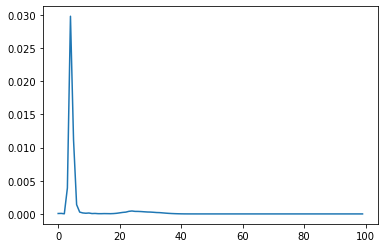

In [11]:
# Test it out if desired
# let's select some ON parasols from the first dataset
indices = ct.cell_selection(types=['ON parasol'])

# Let's grab the first one and see what it has in there
id = indices[0]
print(id) # see the piece_id, cell_id
cell = ct.get_cell(id)
print(cell['piece_id'])
print(cell)

# Let's plot the ACF:
plt.figure()
plt.plot(cell['acf'].a)
plt.show()


In [53]:
# Drop Large Columns and Columns not Critical to Deep Learning Features
# if the ct is very large we'll drop the big columns like STA and EI to save disk space, as they can be
# easily reloaded later as needed
drop_big_columns = ct.unit_table.shape[0] > 10000
# Removed 'ei' from big_columns_per_dataset b/c will likely use
big_columns_per_dataset = ['ei','alex_id','spike_times','spike_count','spike_waveform_maxenergy','spike_waveform_smart','ei_edge','ei_peak','ei_axon_only','ei_energy_raw','map_ei_energy','map_ei_energy_early','map_ei_energy_late']

# now generate the features we listed above, and display the resulting units_table
# check out all of those new columns, which you can use to make your analysis
ct.generate_features('all', features_to_generate_by_dataset, features_to_generate_overall,
                     force_features=False,
                     load_analysis_data=True,
                     ignore_errors=False,
                     drop_big_columns=True,
                     big_columns_per_dataset=big_columns_per_dataset)
display(ct.unit_table)

~ Activating per-dataset features ["<class 'features.Feature_load_manual_labels'>", "<class 'features.Feature_load_dataset_metadata'>", "<class 'features_electrical.Feature_load_spike_times'>", "<class 'features_electrical.Feature_spikes_basic'>", "<class 'features_electrical.Feature_load_ei'>", "<class 'features_electrical.Feature_generate_acf_from_spikes'>", "<class 'features_electrical.Feature_spike_waveform'>", "<class 'features_electrical.Feature_ei_correlation_data'>", "<class 'features_electrical.Feature_ei_select_electrodes'>", "<class 'features_electrical.Feature_ei_map'>", "<class 'features_DLelec.Feature_int_piece_id'>", "<class 'features_DLelec.Feature_spec_spike_waveform'>", "<class 'features_DLelec.Feature_spec_acf'>", "<class 'features_DLelec.Feature_retinal_eccentricity'>", "<class 'features_DLelec.Feature_map_early_ei_char'>", "<class 'features_DLelec.Feature_spike_char'>", "<class 'features_DLelec.Feature_axon_vel'>"]
*** timer  started
~ 

Generating features for dat

unit_id           dataset_id run_id  \
piece_id     run_id unit_id                                        
2017-08-14-1 000    18          18.0  (2017-08-14-1, 000)    000   
                    62          62.0  (2017-08-14-1, 000)    000   
                    77          77.0  (2017-08-14-1, 000)    000   
                    136        136.0  (2017-08-14-1, 000)    000   
                    172        172.0  (2017-08-14-1, 000)    000   
...                              ...                  ...    ...   
2022-05-16-3 005    7636      7636.0  (2022-05-16-3, 005)    005   
                    7642      7642.0  (2022-05-16-3, 005)    005   
                    7655      7655.0  (2022-05-16-3, 005)    005   
                    7667      7667.0  (2022-05-16-3, 005)    005   
                    7669      7669.0  (2022-05-16-3, 005)    005   

                                 piece_id valid label_manual_text_input  \
piece_id     run_id unit_id                                               
2017-08-14-1 000    18       2017-08-14-1  True               ON midget   
                    62       2017-08-14-1  True             OFF parasol   
                    77       2017-08-14-1  True               ON midget   
                    136      2017-08-14-1  True               ON midget   
                    172      2017-08-14-1  True             OFF parasol   
...                                   ...   ...                     ...   
2022-05-16-3 005    7636     2022-05-16-3  True              ON parasol   
                    7642     2022-05-16-3  True             OFF parasol   
                    7655     2022-05-16-3  True                    crap   
                    7667     2022-05-16-3  True              ON parasol   
                    7669     2022-05-16-3  True             OFF parasol   

                             spike_duration  spike_rate_mean   acf  \
piece_id     run_id unit_id                                          
2017-08-14-1 000    18           1799.92845         8.018652  a100   
                    62           1799.95995         4.971222  a100   
                    77           1799.98045         5.066166  a100   
                    136          1799.99850         6.963895  a100   
                    172          1799.98465         4.666151  a100   
...                                     ...              ...   ...   
2022-05-16-3 005    7636          899.85945        13.367643  a100   
                    7642          899.93030        10.179677  a100   
                    7655          899.85000        15.610380  a100   
                    7667          899.98420        14.102470  a100   
                    7669          899.92950         7.009438  a100   

                            spike_waveform_maxamplitude  ...  \
piece_id     run_id unit_id                              ...   
2017-08-14-1 000    18                              a65  ...   
                    62                              a65  ...   
                    77                              a65  ...   
                    136                             a65  ...   
                    172                             a65  ...   
...                                                 ...  ...   
2022-05-16-3 005    7636                           a111  ...   
                    7642                           a111  ...   
                    7655                           a111  ...   
                    7667                           a111  ...   
                    7669                           a111  ...   

                             spike_area_tr_amp_lower  spike_slope_amp_upper  \
piece_id     run_id unit_id                                                   
2017-08-14-1 000    18                   3359.448189               8.852301   
                    62                   2332.446442               7.068020   
                    77                   3888.129890               8.348105   
                    136      

In [54]:
# this function will save the units, cells, and dataset_table row in its own table
# the save_name argument is specific to you and this project, always, and saves your dataset_table in a
# single file so you can easily reload the whole set of datasets

save_name = 'test45to52'  
scratch_file_root = '/Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/' # replace my name!

save_file = 1

if save_file:
    ct.file_save_pieces(save_name=save_name, file_root=scratch_file_root)
else:
    print('NO SAVE')

~ Saving 7 pieces, to /Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/
~ Saving entire datasets table for later per-piece file loading
~ glady saved the whole dataset_table to /Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/ctds_test45to52.pkl
*** timer  started
~ piece_id 2017-08-14-1 with 1 runs, 380 cells, 380 units
~ Saved datasets, cells, units to pandas DataFrames at
/Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/ctd_2017-08-14-1_[d,c,u].pkl
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (1/7) (26.7 / sec)
~ piece_id 2017-10-30-7 with 1 runs, 576 cells, 576 units
~ Saved datasets, cells, units to pandas DataFrames at
/Volumes/Scratch/Users/mads/celltable_datasets/featExtractDL/test/ctd_2017-10-30-7_[d,c,u].pkl
*** elapsed 0s of 0s = 0.0m elapsed, of 0.0m estimated (2/7) (23.4 / sec)
~ piece_id 2018-02-06-4 with 1 runs, 603 cells, 603 units
~ Saved datasets, cells, units to pandas DataFrames at
/Volumes/Scratch/Users/m